##Task 1: Data Understanding and Visualization

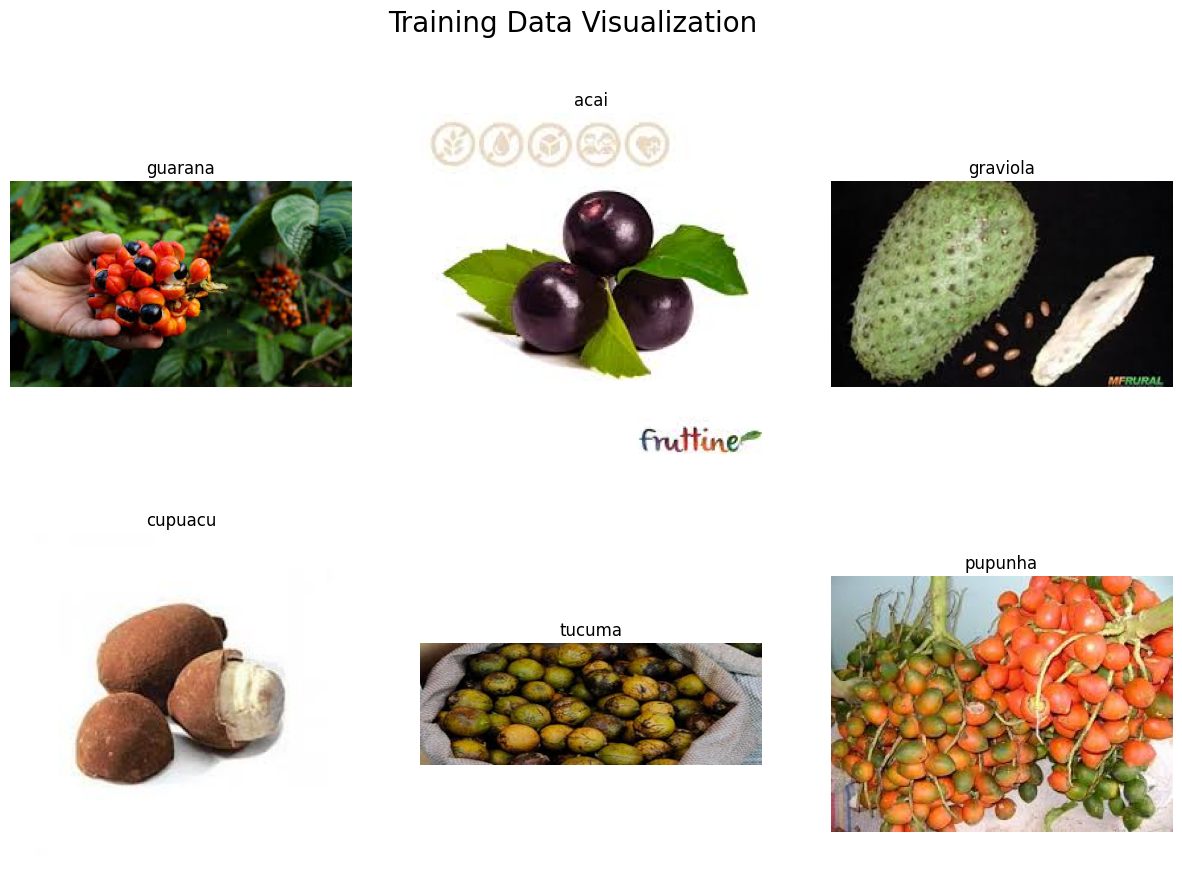

In [40]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random

train_dir = '/content/drive/MyDrive/AI and ML/Week 5/FruitinAmazon/FruitinAmazon/train'
test_dir = '/content/drive/MyDrive/AI and ML/Week 5/FruitinAmazon/FruitinAmazon/test'

# Get list of class directories
class_dirs = [os.path.join(train_dir, d) for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Select one image randomly from each class
images = []
for class_dir in class_dirs:
    img_files = [f for f in os.listdir(class_dir) if f.endswith(('.jpeg'))]
    if img_files:
        img_path = os.path.join(class_dir, random.choice(img_files))
        images.append(img_path)

# Display images in a grid format
plt.figure(figsize=(15, 10))
plt.suptitle("Training Data Visualization", fontsize=20)
for i, img_path in enumerate(images):
    plt.subplot(2, len(images)//2 + len(images)%2, i+1)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(os.path.basename(os.path.dirname(img_path)))
    plt.axis('off')
plt.show()

**What did you observe?**

The dataset contains diverse fruit classes, each with unique colors, textures, and shapes. Images are well-lit and organized in a grid. Potential challenges include class imbalance and variability. Preprocessing and data augmentation can improve model performance.

###Check for Corrupted Images

In [41]:
def check_corrupted_images(directory):
    corrupted_images = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                try:
                    img = Image.open(file_path)
                    img.verify()  # Verify that it is, in fact, an image
                except (IOError, SyntaxError) as e:
                    print(f"Removed corrupted image: {file_path}")
                    corrupted_images.append(file_path)
                    os.remove(file_path)
    if not corrupted_images:
        print("No corrupted images found.")

check_corrupted_images(train_dir)
check_corrupted_images(test_dir)

No corrupted images found.
No corrupted images found.


##Task 2: Loading and Preprocessing Image Data in Keras

In [42]:
import tensorflow as tf

# Define image size and batch size
img_height, img_width = 128, 128
batch_size = 16
validation_split = 0.2

# Create a preprocessing layer for normalization
rescale = tf.keras.layers.Rescaling(1./255)

# Create training dataset with normalization
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

# Apply the normalization (Rescaling) to the dataset
train_ds = train_ds.map(lambda x, y: (rescale(x), y))

# Load and preprocess test data
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    seed=123
)
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 30 files belonging to 6 classes.


##Task 3 - Implement a CNN with

In [43]:
import tensorflow as tf

num_classes = len(os.listdir(train_dir))

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,213,222 (16.07 MB)

 Trainable params: 4,213,222 (16.07 MB)

 Non-trainable params: 0 (0.00 B)

##Task 4: Compile the Model


In [44]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

##Task 5: Train the model

In [45]:
import tensorflow as tf

checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = model.fit(
    train_ds,
    epochs=250,
    validation_data=test_ds,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2253 - loss: 2.0738
Epoch 1: val_loss improved from inf to 1.79822, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 409ms/step - accuracy: 0.2202 - loss: 2.0746 - val_accuracy: 0.2333 - val_loss: 1.7982
Epoch 2/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.2413 - loss: 1.7085
Epoch 2: val_loss improved from 1.79822 to 1.64702, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 375ms/step - accuracy: 0.2451 - loss: 1.7016 - val_accuracy: 0.3333 - val_loss: 1.6470
Epoch 3/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.3406 - loss: 1.4861
Epoch 3: val_loss improved from 1.64702 to 1.49707, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 365ms/step - accuracy: 0.3533 - loss: 1.4662 - val_accuracy: 0.3667 - val_loss: 1.4971
Epoch 4/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.7035 - loss: 1.0071
Epoch 4: val_loss improved from 1.49707 to 1.15909, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 382ms/step - accuracy: 0.7089 - loss: 0.9951 - val_accuracy: 0.5000 - val_loss: 1.1591
Epoch 5/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9170 - loss: 0.5238
Epoch 5: val_loss did not improve from 1.15909
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 590ms/step - accuracy: 0.9146 - loss: 0.5198 - val_accuracy: 0.6333 - val_loss: 1.2002
Epoch 6/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9024 - loss: 0.2574
Epoch 6: val_loss did not improve from 1.15909
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 348ms/step - accuracy: 0.9025 - loss: 0.2617 - val_accuracy: 0.5333 - val_loss: 1.8765
Epoch 7/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.8528 - loss: 0.2586
Epoch 7: val_loss improved from 1.15909 to 1.10049, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step - accuracy: 0.8588 - loss: 0.2554 - val_accuracy: 0.5000 - val_loss: 1.1005
Epoch 8/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 1.0000 - loss: 0.1067
Epoch 8: val_loss did not improve from 1.10049
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 325ms/step - accuracy: 1.0000 - loss: 0.1033 - val_accuracy: 0.6333 - val_loss: 1.1591
Epoch 9/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 1.0000 - loss: 0.0522
Epoch 9: val_loss improved from 1.10049 to 0.92048, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 356ms/step - accuracy: 1.0000 - loss: 0.0530 - val_accuracy: 0.7000 - val_loss: 0.9205
Epoch 10/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9941 - loss: 0.0265
Epoch 10: val_loss improved from 0.92048 to 0.80473, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 537ms/step - accuracy: 0.9928 - loss: 0.0300 - val_accuracy: 0.7333 - val_loss: 0.8047
Epoch 11/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9872 - loss: 0.0242
Epoch 11: val_loss improved from 0.80473 to 0.77383, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 486ms/step - accuracy: 0.9847 - loss: 0.0272 - val_accuracy: 0.8000 - val_loss: 0.7738
Epoch 12/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9941 - loss: 0.0229
Epoch 12: val_loss did not improve from 0.77383
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 318ms/step - accuracy: 0.9928 - loss: 0.0249 - val_accuracy: 0.5000 - val_loss: 1.2283
Epoch 13/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 1.0000 - loss: 0.0170
Epoch 13: val_loss improved from 0.77383 to 0.68613, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 349ms/step - accuracy: 1.0000 - loss: 0.0168 - val_accuracy: 0.8000 - val_loss: 0.6861
Epoch 14/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 1.0000 - loss: 0.0064
Epoch 14: val_loss did not improve from 0.68613
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 337ms/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 0.7333 - val_loss: 0.8066
Epoch 15/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 1.0000 - loss: 0.0070
Epoch 15: val_loss did not improve from 0.68613
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 334ms/step - accuracy: 1.0000 - loss: 0.0069 - val_accuracy: 0.7000 - val_loss: 0.8772
Epoch 16/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 1.0000 - loss: 0.0029
Epoch 16: val_loss did not improve from 0.68613
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 566ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.7333 - val_loss: 0.9052
Epoch 17/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 1.0000 - loss: 0.0017
Epoch 17: val_loss did not improve from 0.68613
5/5 

##Task 6: Evaluate the Model

In [46]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8042 - loss: 0.6026
Test accuracy: 0.8000


##Task 7: Save and Load the Model


In [47]:
# Save the model
model.save("final_model.h5")

# Load the saved model
loaded_model = tf.keras.models.load_model("final_model.h5")

# Re-evaluate the loaded model
test_loss_loaded, test_acc_loaded = loaded_model.evaluate(test_ds)
print(f"Loaded Model Test accuracy: {test_acc_loaded:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.8042 - loss: 0.6026
Loaded Model Test accuracy: 0.8000


##Task 8: Predictions and Classification Report

In [48]:
from sklearn.metrics import classification_report
import numpy as np

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_prob = loaded_model.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

class_names = os.listdir(train_dir)
print(classification_report(y_true, y_pred, target_names=class_names))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
              precision    recall  f1-score   support

     guarana       0.83      1.00      0.91         5
        acai       0.75      0.60      0.67         5
    graviola       0.62      1.00      0.77         5
     cupuacu       1.00      0.80      0.89         5
      tucuma       0.83      1.00      0.91         5
     pupunha       1.00      0.40      0.57         5

    accuracy                           0.80        30
   macro avg       0.84      0.80      0.79        30
weighted avg       0.84      0.80      0.79        30



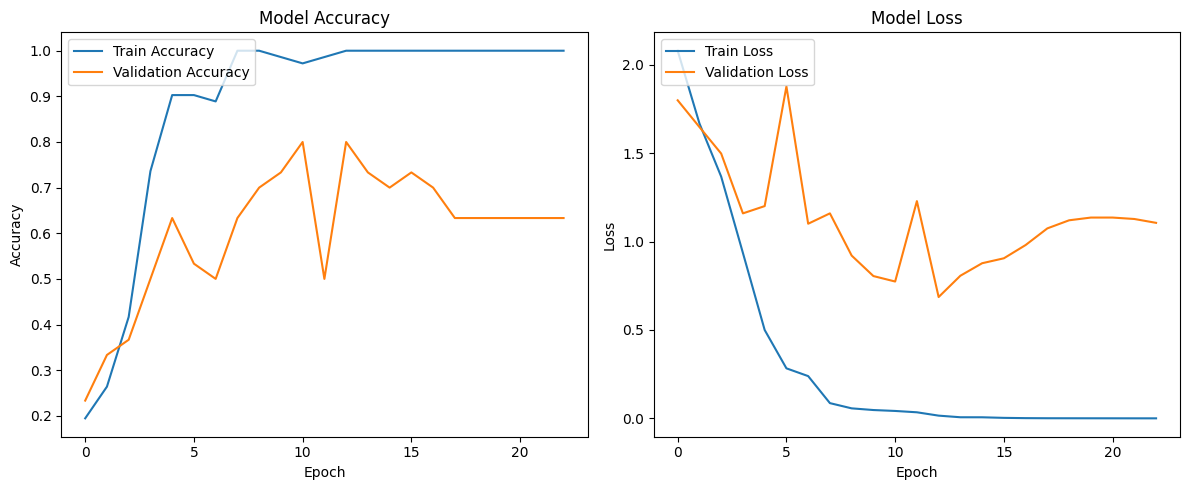

In [49]:
import matplotlib.pyplot as plt

# Function to plot training and validation metrics
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the function to visualize training history
plot_training_history(history)

##Save the model

In [51]:
# Save the final trained model
model.save("/content/drive/MyDrive/AI and ML/Week 5/final_model.h5")

# Load the saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/AI and ML/Week 5/final_model.h5")

# Re-evaluate the loaded model on the test dataset
test_loss_loaded, test_acc_loaded = loaded_model.evaluate(test_ds)
print(f"Loaded Model Test Accuracy: {test_acc_loaded:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - accuracy: 0.8042 - loss: 0.6026
Loaded Model Test Accuracy: 0.8000
